In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import matplotlib.dates as mdates
import requests
import glob
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import os
import re
from scipy.stats import pearsonr




In [123]:

# 최적 지연 기간 찾기 함수
def find_optimal_lags_with_confidence(fish_prices, weather_data, feature_list, max_lag=600, bootstrap_samples=50):
    results = {}

    for feature in feature_list:
        print(feature, feature_list)
        best_corr = -1
        best_lag = 0
        bootstrap_lags = []

        for lag in range(1, max_lag + 1):
            shifted_prices = fish_prices.copy()
            shifted_prices['날짜'] = shifted_prices['날짜'] - pd.Timedelta(days=lag)

            shifted_prices.dropna(inplace=True)
            # print(shifted_prices)
            merged_df = pd.merge(shifted_prices, weather_data[['날짜', feature]], on='날짜', how='inner')
            # merged_df.info()
            if merged_df.empty:
                continue

            # 상관관계 분석
            scaler = StandardScaler()
            weather_scaled = scaler.fit_transform(merged_df[[feature]])
            price_scaled = scaler.fit_transform(merged_df[['avgPrice']])
            # print(weather_scaled)
            # print(price_scaled)

            corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())

            if corr > best_corr:
                best_corr = corr
                best_lag = lag

        # 부트스트래핑을 통한 신뢰 구간 계산
        for _ in range(bootstrap_samples):
            # sampled_indices = np.random.choice(len(fish_prices), len(fish_prices), replace=True)
            sampled_indices = np.random.choice(len(merged_df), len(merged_df), replace=True)
            # sampled_prices = fish_prices.iloc[sampled_indices]
            sampled_merged = merged_df.iloc[sampled_indices]
            # shifted_sample = sampled_prices.copy()
            # shifted_sample.dropna(inplace=True)
            # shifted_sample['날짜'] = shifted_sample['날짜'] - pd.Timedelta(days=best_lag)
            # sampled_merged = pd.merge(shifted_sample, weather_data[['날짜', feature]], on='날짜', how='inner')

            if not sampled_merged.empty:
                weather_scaled = scaler.fit_transform(sampled_merged[[feature]])
                price_scaled = scaler.fit_transform(sampled_merged[['avgPrice']])
                boot_corr, _ = pearsonr(price_scaled.flatten(), weather_scaled.flatten())
                bootstrap_lags.append(boot_corr)

        conf_low, conf_high = np.percentile(bootstrap_lags, [2.5, 97.5])

        results[feature] = {
            '최적 지연 기간': best_lag,
            '상관계수': best_corr,
            '신뢰구간': (conf_low, conf_high)
        }

    return results
    

In [124]:

# 가격 지연 최적치 함수수
def lags(Market, Item):
    # 데이터 로드 및 전처리
    price_data = pd.read_csv('../../data/prep/item_price_filled_pivot.csv', encoding='utf-8-sig')
    price_data['날짜'] = pd.to_datetime(price_data['priceDate']).dt.date

    # 특정 시장과 품목의 가격 필터링
    data_noryang = price_data[price_data['market'] == Market]
    data_noryang = data_noryang.filter(items=['날짜', f'{Item}_avgPrice'])

    daily_avg_price = data_noryang.groupby('날짜').mean().reset_index()
    daily_avg_price.rename(columns={f'{Item}_avgPrice': 'avgPrice'}, inplace=True)

    # 기상 데이터 불러오기 및 전처리
    forecast_df = pd.read_csv('../../data/prep/forecast_agg.csv', encoding='utf-8-sig')
    forecast_df['날짜'] = pd.to_datetime(forecast_df['일시']).dt.date
    forecast_df = forecast_df.drop(columns=['지점', '일시'])
    daily_avg_weather = forecast_df.groupby('날짜').mean(numeric_only=True).reset_index()

    # daily_avg_weather.info()
    # print("daw:", daily_avg_weather)
    # 분석 수행
    feature_columns = daily_avg_weather.columns.drop('날짜')
    print(feature_columns)
    # daily_avg_weather.info()
    # print("dap:", daily_avg_price)
    # daily_avg_price.info()
    # print(feature_columns)
    optimal_lags_with_confidence = find_optimal_lags_with_confidence(daily_avg_price, daily_avg_weather, feature_columns)

    # 결과 출력
    print(f"\n가격 기준 기상 요인의 최적 지연 기간 및 신뢰구간(품목={Item}/ 시장={Market}/ 부이=평균):")
    for feature, result in optimal_lags_with_confidence.items():
        print(f"{feature}: {result['최적 지연 기간']}일, 상관계수: {result['상관계수']:.4f}, 신뢰구간: {result['신뢰구간'][0]:.4f} ~ {result['신뢰구간'][1]:.4f}, 범위: {result['신뢰구간'][1] - result['신뢰구간'][0]:.4f}")

    # 시각화
    plt.figure(figsize=(12, 8))
    sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],
                y=list(optimal_lags_with_confidence.keys()),
                palette='viridis')
    plt.title(f'{Market} {Item} 가격에 대한 기상 요인의 최적 지연 기간')
    plt.xlabel('최적 지연 기간 (일)')
    plt.ylabel('기상 요인')
    plt.grid()
    plt.show()

Index(['풍속', 'GUST풍속', '현지기압', '습도', '기온', '수온', '최대파고', '유의파고', '평균파고',
       '파주기'],
      dtype='object')
풍속 Index(['풍속', 'GUST풍속', '현지기압', '습도', '기온', '수온', '최대파고', '유의파고', '평균파고',
       '파주기'],
      dtype='object')
GUST풍속 Index(['풍속', 'GUST풍속', '현지기압', '습도', '기온', '수온', '최대파고', '유의파고', '평균파고',
       '파주기'],
      dtype='object')
현지기압 Index(['풍속', 'GUST풍속', '현지기압', '습도', '기온', '수온', '최대파고', '유의파고', '평균파고',
       '파주기'],
      dtype='object')
습도 Index(['풍속', 'GUST풍속', '현지기압', '습도', '기온', '수온', '최대파고', '유의파고', '평균파고',
       '파주기'],
      dtype='object')
기온 Index(['풍속', 'GUST풍속', '현지기압', '습도', '기온', '수온', '최대파고', '유의파고', '평균파고',
       '파주기'],
      dtype='object')
수온 Index(['풍속', 'GUST풍속', '현지기압', '습도', '기온', '수온', '최대파고', '유의파고', '평균파고',
       '파주기'],
      dtype='object')
최대파고 Index(['풍속', 'GUST풍속', '현지기압', '습도', '기온', '수온', '최대파고', '유의파고', '평균파고',
       '파주기'],
      dtype='object')
유의파고 Index(['풍속', 'GUST풍속', '현지기압', '습도', '기온', '수온', '최대파고', '유의파고', '평균파고',
       '파주기']

C:\Users\user\AppData\Local\Temp\ipykernel_40872\1902330274.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[res['최적 지연 기간'] for res in optimal_lags_with_confidence.values()],


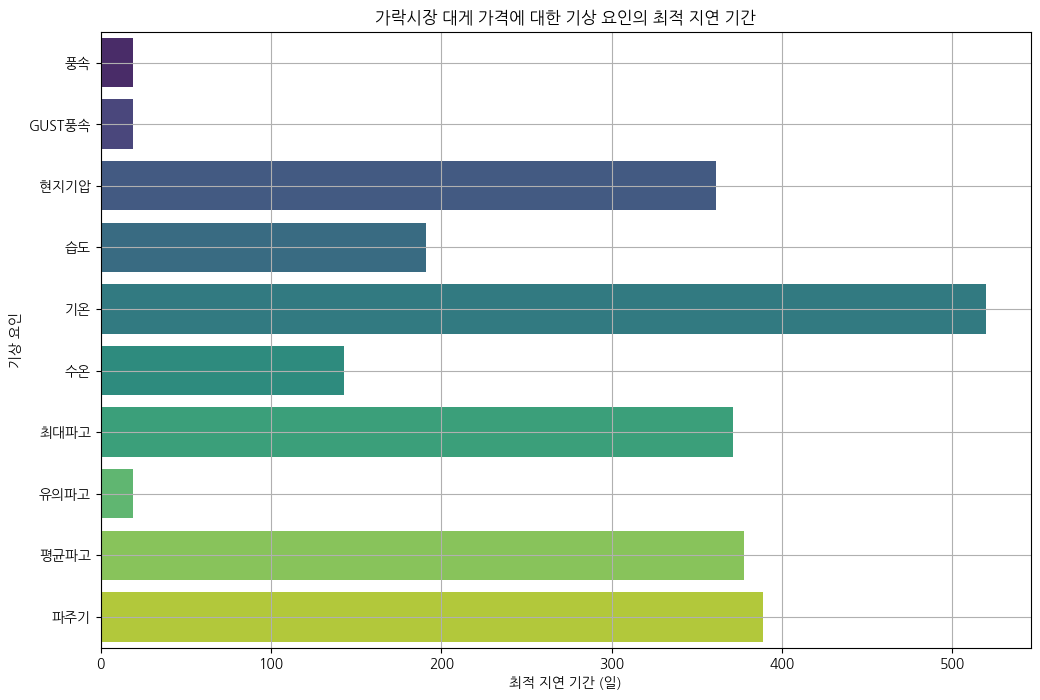

In [125]:
# # 함수 호출
# markets = ['가락시장', '노량진 1층']
# items = ['대게', '참돔']
# for market in markets:
#     for item in items:
#         lags(market, item)

lags(Market="가락시장", Item="대게")

In [52]:
forecast_df = pd.read_csv('../../data/prep/forecast_agg.csv', encoding='utf-8-sig')
forecast_df['날짜'] = pd.to_datetime(forecast_df['일시'])
forecast_df.info()
forecast_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23741 entries, 0 to 23740
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   지점      23741 non-null  int64         
 1   일시      23741 non-null  object        
 2   풍속      23325 non-null  float64       
 3   GUST풍속  23228 non-null  float64       
 4   현지기압    23641 non-null  float64       
 5   습도      23326 non-null  float64       
 6   기온      23482 non-null  float64       
 7   수온      23497 non-null  float64       
 8   최대파고    23702 non-null  float64       
 9   유의파고    23701 non-null  float64       
 10  평균파고    23683 non-null  float64       
 11  파주기     23688 non-null  float64       
 12  날짜      23741 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(10), int64(1), object(1)
memory usage: 2.4+ MB


,지점,일시,풍속,GUST풍속,현지기압,습도,기온,수온,최대파고,유의파고,평균파고,파주기,날짜
0,22105,2015-01-01,10.808696,15.126087,1016.200000,65.130435,-0.121739,13.752174,6.7,3.095652,1.547826,8.165217,2015-01-01
1,22105,2015-01-02,9.725000,13.791667,1018.875000,60.083333,1.029167,13.262500,6.5,2.683333,1.341667,7.816667,2015-01-02
2,22105,2015-01-03,3.520833,6.083333,1019.725000,39.750000,4.337500,13.391667,4.2,1.625000,0.812500,7.483333,2015-01-03
3,22105,2015-01-04,4.558333,6.695833,1015.858333,54.000000,8.091667,13.862500,2.4,1.108333,0.554167,5.954167,2015-01-04
4,22105,2015-01-05,6.708696,8.939130,1016.352174,57.086957,10.613043,13.608696,3.6,1.060870,0.521739,4.739130,2015-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23736,22305,2024-11-19,3.641667,5.437500,1030.700000,51.625000,9.258333,17.062500,2.4,1.004167,0.654167,6.229167,2024-11-19
23737,22305,2024-11-20,7.466667,9.854167,1021.891667,51.583333,11.937500,16.850000,3.5,1.079167,0.687500,5.075000,2024-11-20
23738,22305,2024-11-21,8.333333,10.666667,1017.745833,51.750000,12.854167,17.212500,2.2,0.962500,0.620833,4.820833,2024-11-21
23739,22305,2024-11-22,10.116667,13.275000,1020.795833,49.666667,10.362500,16.141667,4.1,1.904167,1.225000,5.808333,2024-11-22
